In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

# custom packages
# custom package where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator

# Sobol Indices

In [ ]:
def pick_and_freeze(model,t,A,B):
    
    '''
    Point-wise first and total order Sobol Indices

    Inputs:
        model = function that returns output of model for given input
        t = time to at which model must be evaluated
        A = First set of random inputs of size [N,n]
        B = Second set of random inputs of size [N,n] 
        
    Outputs:
        S = [n,1] vector
            First-order sensitivity of each the 'n' parameters
            at time 't'. 
            
        S_T = [n,1] vector
              Total sensitivity of each the 'n' parameters
              at time 't'.
              
    '''
    n = A.shape[1] # number of variables
    N = A.shape[0] # number of MC samples
    
    def get_C_i(i):
        C_i = np.copy(B)
        C_i[:,i] = A[:,i]
        return C_i

    f_A = model(A,t).flatten() # [N,1] vector with evaluations at x_A, (flatten for broadcasting)
    f_B = model(B,t).flatten() # [N,1] vector with evaluations at x_B, (flatten for broadcasting)

    f_0 = np.mean(f_A) # scalar

    S = np.zeros((n,1))
    S_T = np.zeros((n,1)) 

    for i in range(n):
        f_C = model(get_C_i(i),t).flatten()

        # denominator is common in both terms
        # V[Y] = E[Y**2] - E[Y]**2
        total_variance = (np.dot(f_A,f_A)/N) - f_0**2
                        
        # First order indices
        S[i] = ( (np.dot(f_A,f_C)/N) - f_0**2 )  / ( total_variance )
        
        #Total indices
        S_T[i] = 1 - ( (np.dot(f_B,f_C)/N - f_0**2) ) / ( total_variance )  
        
    return S, S_T

# Pointwise-in-time Sobol Indices

Using Pick and Freeze method

In [3]:
def pick_and_freeze(model, I, N, N_p, A, B):
    """
    Point-wise first and total order Sobol Indices

    Inputs:
        model = function that returns output of model for given input
                Input:  ndarray
                        [N, N_p]
                Output: [n_t, N]
                        Model evaluations for desired set of parameters
                        Each column has ouput of 1 set of parameters
        I = list or 1D array
            Indices in solution at which Sobol indices must be computed
        N = int
            number of MC samples
        N_p = int
              number of parameters
        A = ndarray
            First set of random inputs of size [N, N_p]
        B = ndarray
            Second set of random inputs of size [N, N_p]
        
    Outputs:
        S = ndarray
            [n, num_of_points] 
            num_of_points = len(num_of_points)
            First-order sensitivity of each the 'n' parameters
            at each I 

        S_T = ndarray
              [n,1]
              num_of_points = len(num_of_points)
              Total sensitivity of each the 'n' parameters
              at each I
    """

    def get_C_i(i):
        C_i = np.copy(B)
        C_i[:,i] = A[:,i]
        return C_i

    f_A = model(A) # [n_t, N] vector with evaluations at x_A
    f_B = model(B) # [n_t, N] vector with evaluations at x_B

    # store f_C
    f_C = np.zeros((f_A.shape[0], f_A.shape[1], N_p)) # [n_t, N, N_p] 3d array with evaluations at x_C_i

    for i in tqdm(range(N_p), desc = 'Computing f_C', ncols=100):
        f_C[:, :, i] = model(get_C_i(i)) # [n_t, N] vector with evaluations at x_C_i

    f_0 = np.mean(f_A, axis=1) # [n_t, 1] mean over N realisation for each discretisation point

    num_of_points = len(I)

    S = np.zeros((N_p, num_of_points))
    S_T = np.zeros((N_p, num_of_points))

    for j, time_index in enumerate(tqdm(I, desc = 'Computing Indices', ncols=100)):

        for i in range(N_p):
            f_A_local = f_A[time_index, :].T # [N, 1] vector
            f_B_local = f_B[time_index, :].T # [N, 1] vector
            f_C_local = f_C[time_index, :, i].T # [N, 1] vector
            f_0_local = f_0[time_index]

            # denominator is common in both terms
            # V[Y] = E[Y**2] - E[Y]**2
            total_variance = (np.dot(f_A_local, f_A_local)/N) - f_0_local**2

            # First order indices
            # Each column contains indices corresponding to a point in I
            S[i, j] = ( (np.dot(f_A_local, f_C_local)/N) - f_0_local**2 )  / ( total_variance )

            # Total indices
            # Each column contains indices corresponding to a point in I
            S_T[i, j] = 1 - ( (np.dot(f_B_local, f_C_local)/N - f_0_local**2) ) / ( total_variance )  

    return S, S_T

# Model

In [4]:
def mech_oscillator_wrapper(parameters):
    """
    Wrapper to get function with signature:  model(A)

    Inputs:
    A : [N, 3] matrix
        0: alpha
        1: beta
        2: l
        Each column contains N realisations of each random variable  
        Each row contains one set of realisations

    Outputs:
        [N, 1] column vector
        N model evaluations
    """

    return mech_oscillator(parameters, T).T

# Computation

In [5]:
N = 100_000 # number of MC samples
N_p = 3 # number of parameters

X = mech_oscillator_samples(2*N)

A1 = X[:N, :]
B1 = X[N:, :]

n_t = 200  # discretization in time
T = np.linspace(0, 10, n_t+1) # row vector

inspection_points = 201

I = np.linspace(0 , n_t, inspection_points, dtype=int)

print(f'Total number of function evalutions = {N*(N_p+2)}')

S, S_T = pick_and_freeze(mech_oscillator_wrapper, I, N, N_p, A1, B1)

Total number of function evalutions = 500000


Computing Indices: 100%|█████████████████████████████████████████| 201/201 [00:00<00:00, 622.70it/s]


# Plot

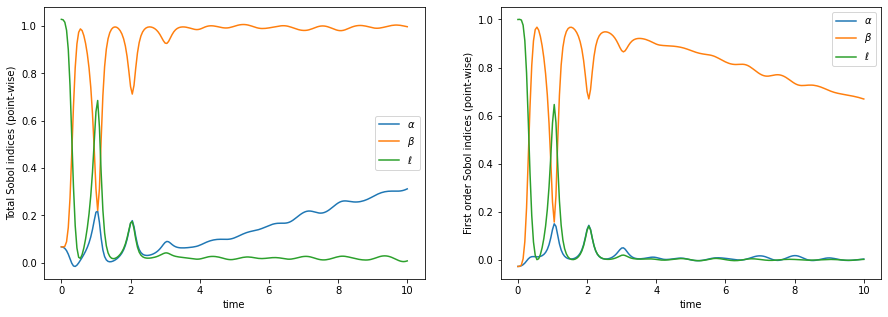

In [6]:
fig, ax = plt.subplots(1, 2,figsize=(15,5))

ax[0].plot(T[I], S_T[0,:], '-', label = r'$\alpha$')
ax[0].plot(T[I], S_T[1,:], '-', label = r'$\beta$')
ax[0].plot(T[I], S_T[2,:], '-', label = r'$\ell$')
ax[0].legend()
ax[0].set_xlabel('time')
ax[0].set_ylabel('Total Sobol indices (point-wise)')

ax[1].plot(T[I], S[0,:], '-', label = r'$\alpha$')
ax[1].plot(T[I], S[1,:], '-', label = r'$\beta$')
ax[1].plot(T[I], S[2,:], '-', label = r'$\ell$')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('First order Sobol indices (point-wise)')

plt.show()